In [2]:
%load_ext autoreload
%autoreload 2
import sys

# insert at 1, 0 is the script path (or ‘’ in REPL)
sys.path.insert(1, '../')


import numpy as np
import torch
from torch.utils.data import DataLoader
from bayesian_neural_net import CLSTM_cell
from bayesian_neural_net import ConvCell
from bayesian_neural_net import ConvRelu
from bayesian_neural_net import DeconvRelu
from bayesian_neural_net import Encoder_pro
from bayesian_neural_net import Decoder_pro
from bayesian_neural_net import ED_pro
from bayesian_neural_net import Bidirectional_ED_pro


from simulation_dataset import MovingMNIST2
from simulation_dataset_datamodule import DatasetDataModule
from trainer import LightningED2
from visualization import plot_spatio_temporal_data

import pytorch_lightning as pl

import copy

# set the seed globally for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [3]:
root = '../../data'
n_frames = 20
num_digits = 2
image_size = 64
digit_size = 28
N = 10 # total number of samples including training and validation data
mask = np.ones((N, n_frames)) * np.array([1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1])
data = MovingMNIST2( root,
                     n_frames,
                     mask,
                     num_digits,
                     image_size,
                     digit_size,
                     N,
                     transform=None,
                     use_fixed_dataset=False)

data_module = DatasetDataModule(data, 1, 0.5)

# build the model
# encoder pro
rnns = [CLSTM_cell(shape=(64, 64), input_channels=16, filter_size=5, num_features=64,
                   dropout_rate=0.),
        CLSTM_cell(shape=(32, 32), input_channels=64, filter_size=5, num_features=96, dropout_rate=0.),
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.) ]

convrelus = [ConvRelu(1, 16, 3, 1, 1, dropout_rate=0.),
             ConvRelu(64, 64, 3, 2, 1, dropout_rate=0.),
             ConvRelu(96, 96, 3, 2, 1, dropout_rate=0.)]

encoder_net = Encoder_pro(rnns, convrelus)

# input for encoder
S = 10
B = 2
input_channels = 1
H = 64
W = 64
input_for_encoder = [torch.randn(B, S, input_channels, H, W)]

# decoder_pro
rnns = [CLSTM_cell(shape=(16, 16), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.),
        CLSTM_cell(shape=(32, 32), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.),
        CLSTM_cell(shape=(64, 64), input_channels=96, filter_size=5, num_features=64, dropout_rate=0.)]

deconvrelus = [DeconvRelu(96, 96, 4, 2, 1, dropout_rate=0.),
               DeconvRelu(96, 96, 4, 2, 1, dropout_rate=0.),
               DeconvRelu(64, 16, 3, 1, 1, dropout_rate=0.)]

cnn = ConvCell(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder_pro(rnns, deconvrelus, cnn)

# ED_pro net
ED_net1 = ED_pro(encoder_net, decoder_net)
ED_net2 = copy.deepcopy(ED_net1)


# bidirectional_ED_pro
ED_net = Bidirectional_ED_pro(ED_net1, ED_net2)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 1
model = LightningED2(ED_net, mc_dropout, learning_rate)



# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='moving_mnist_imputation.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    print('fail to load the model')
    pass



#logger = TensorBoardLogger('tb_logs', name='Bayesian_ConvLSTM')

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=max_epoch, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=max_epoch)
trainer.fit(model, data_module)



# save the checkpoint
trainer.save_checkpoint("moving_mnist_imputation.ckpt")

GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fail to load the model



  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | Bidirectional_ED_pro | 18.1 M
1 | loss_function | MSELoss              | 0     
-------------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params
72.258    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!


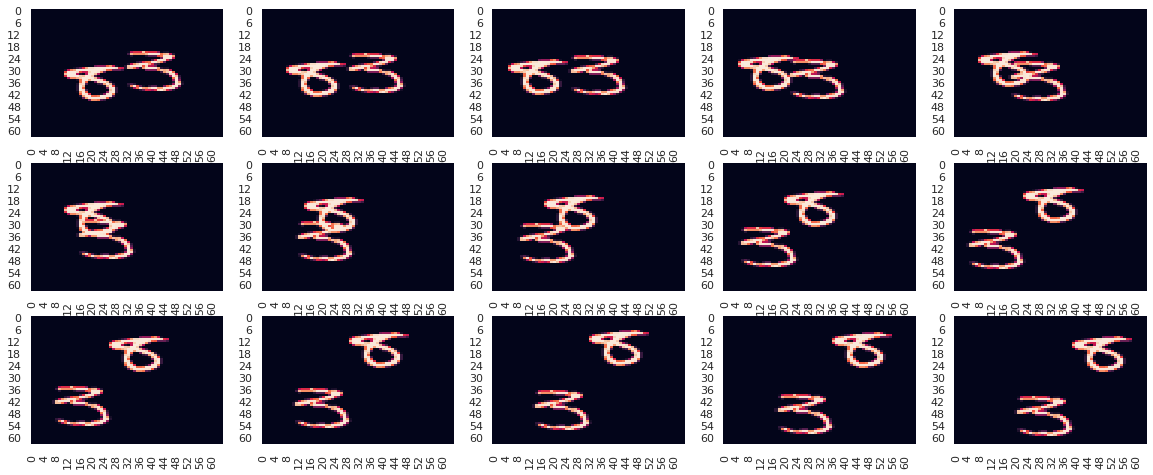

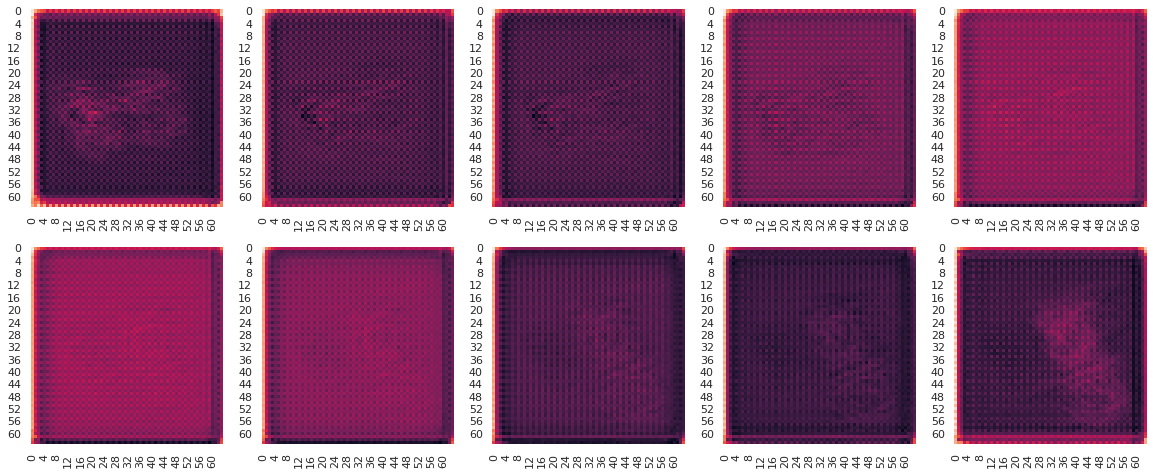

error for the new sample is 0.0449


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root = '../../data'
n_frames = 20
mask = np.ones((N, n_frames)) * np.array([1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1])
num_digits = 2
image_size = 64
digit_size = 28
N = 1  # total number of samples including training and validation data

test_data = MovingMNIST2( root,
                     n_frames,
                     mask,
                     num_digits,
                     image_size,
                     digit_size,
                     N,
                     transform=None,
                     use_fixed_dataset=False)

test_data_loader = DataLoader(test_data, 1)

# build the model
# build the model
# encoder pro
rnns = [CLSTM_cell(shape=(64, 64), input_channels=16, filter_size=5, num_features=64,
                   dropout_rate=0.),
        CLSTM_cell(shape=(32, 32), input_channels=64, filter_size=5, num_features=96, dropout_rate=0.),
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.) ]

convrelus = [ConvRelu(1, 16, 3, 1, 1, dropout_rate=0.),
             ConvRelu(64, 64, 3, 2, 1, dropout_rate=0.),
             ConvRelu(96, 96, 3, 2, 1, dropout_rate=0.)]

encoder_net = Encoder_pro(rnns, convrelus)

# input for encoder
S = 10
B = 2
input_channels = 1
H = 64
W = 64
input_for_encoder = [torch.randn(B, S, input_channels, H, W)]

# decoder_pro
rnns = [CLSTM_cell(shape=(16, 16), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.),
        CLSTM_cell(shape=(32, 32), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.),
        CLSTM_cell(shape=(64, 64), input_channels=96, filter_size=5, num_features=64, dropout_rate=0.)]

deconvrelus = [DeconvRelu(96, 96, 4, 2, 1, dropout_rate=0.),
               DeconvRelu(96, 96, 4, 2, 1, dropout_rate=0.),
               DeconvRelu(64, 16, 3, 1, 1, dropout_rate=0.)]

cnn = ConvCell(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder_pro(rnns, deconvrelus, cnn)

# ED net
ED_net1 = ED_pro(encoder_net, decoder_net)
ED_net2 = copy.deepcopy(ED_net1)

ED_net = Bidirectional_ED_pro(ED_net1, ED_net2)

mc_dropout = 20
learning_rate = 1e-4
max_epoch = 1
model = LightningED2(ED_net, mc_dropout, learning_rate)



# load from checkpoint
model.load_from_checkpoint(checkpoint_path='moving_mnist_imputation.ckpt', bidirectional_ED_pro=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)

model.to(device)  # transfer the model to gpu

# predict for one sample
for idx, batch in enumerate(test_data_loader):

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, true_output, seq_len = batch
    
    true_data = torch.cat((input_for_encoder[0], true_output[0]), 1)
    true_data = true_data.squeeze()



    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]


    output1, output2 = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
    output = [(x + y) / 2 for x, y in zip(output1, output2)]
    
    if idx == 0:
        break
        

# transfer the tensor on gpu on cpu
predicted_data = torch.cat(output, dim=1).cpu().detach().numpy().squeeze(0).squeeze(1)
true_data = true_data.cpu().detach().numpy()

# plot the true data
plot_spatio_temporal_data(true_data)
plot_spatio_temporal_data(predicted_data)


print("error for the new sample is %.4f"%np.mean((predicted_data - true_data[5:15, ...])**2))